$$
\newcommand{\genericdel}[3]{%
      \left#1{#3}\right#2
    }
    \newcommand{\del}[1]{\genericdel(){#1}}
    \newcommand{\sbr}[1]{\genericdel[]{#1}}
    \newcommand{\cbr}[1]{\genericdel\{\}{#1}}
    \newcommand{\abs}[1]{\genericdel||{#1}}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \DeclareMathOperator{\Pr}{\mathbb{p}}
    \DeclareMathOperator{\E}{\mathbb{E}}
    \DeclareMathOperator{\Ind}{\mathbb{I}}
    \DeclareMathOperator{\V}{\mathbb{V}}
    \DeclareMathOperator{\cov}{Cov}
    \DeclareMathOperator{\var}{Var}
    \DeclareMathOperator{\ones}{\mathbf{1}}
    \DeclareMathOperator{\invchi}{\mathrm{Inv-\chi}^2}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \DeclareMathOperator{\normal}{\mathcal{N}}
    \DeclareMathOperator{\unif}{Uniform}
    \DeclareMathOperator{\poisson}{Poisson}
    \DeclareMathOperator{\dif}{d}
    \newcommand{\od}[2]{\frac{\dif{#1}}{\dif{#2}}}
    \DeclareMathOperator{\Forall}{\forall}
    %
    % linear algebra
    %
    \DeclareMathOperator{\ones}{\mathbf{1}}   
    \newcommand{\eye}{\mathbf{I}}
    \newcommand{\trans}{^{\intercal}}
    \DeclareMathOperator{\trace}{trace}
$$

In [1]:
using LaTeXStrings
import PyPlot; plt=PyPlot
plt.rc("figure", dpi=300.0)
# plt.rc("figure", figsize=(6,4))
# plt.rc("figure", autolayout=true)
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
cbbPalette = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
;

In [2]:
using Distributions
using RCall

# Implement Exponential Family w/ Splines

In [3]:
m = 31 # discretization resolution, odd numbers are better
# discretized space of noise-free variables:
θvec = collect(linspace(-3,3,m))
p = 5 # number of parameters
Q = convert(Matrix{Float64}, R"splines::ns($θvec, $p)")
size(Q)

(31, 5)

**Plot spline basis**

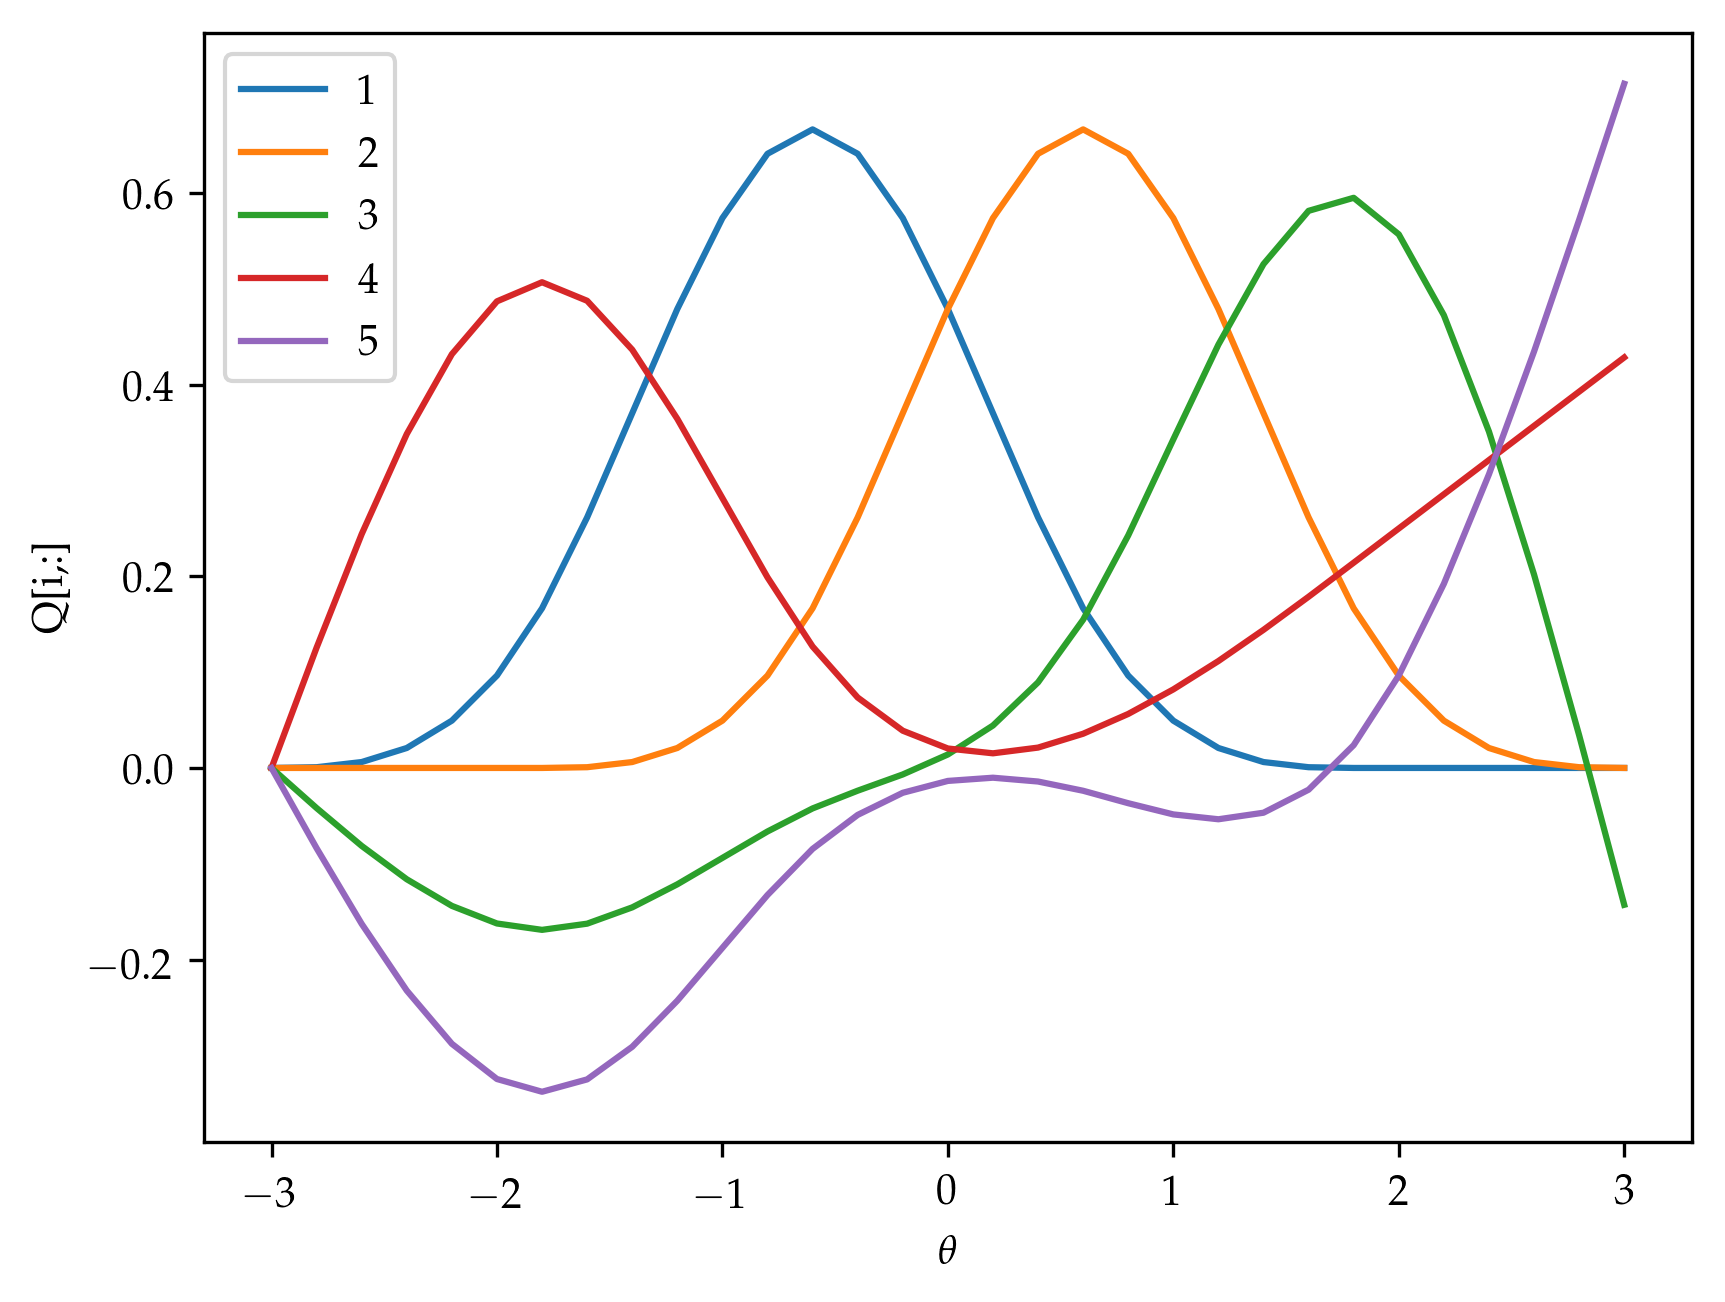

In [4]:
for param in 1:p
    plt.plot(θvec, Q[:, param], label=string(param))
end
plt.legend(loc="best")
plt.xlabel(L"\theta")
plt.ylabel("Q[i,:]")
;

**Generate a random distribution**

We create a random distribution by using random numbers for the parameter vector $\alpha$.

In [5]:
α = randn(p)

expQα = exp.(Q*α)
φ_α = log(sum(expQα))
g_α = exp.(Q*α - φ_α) # normalized
;

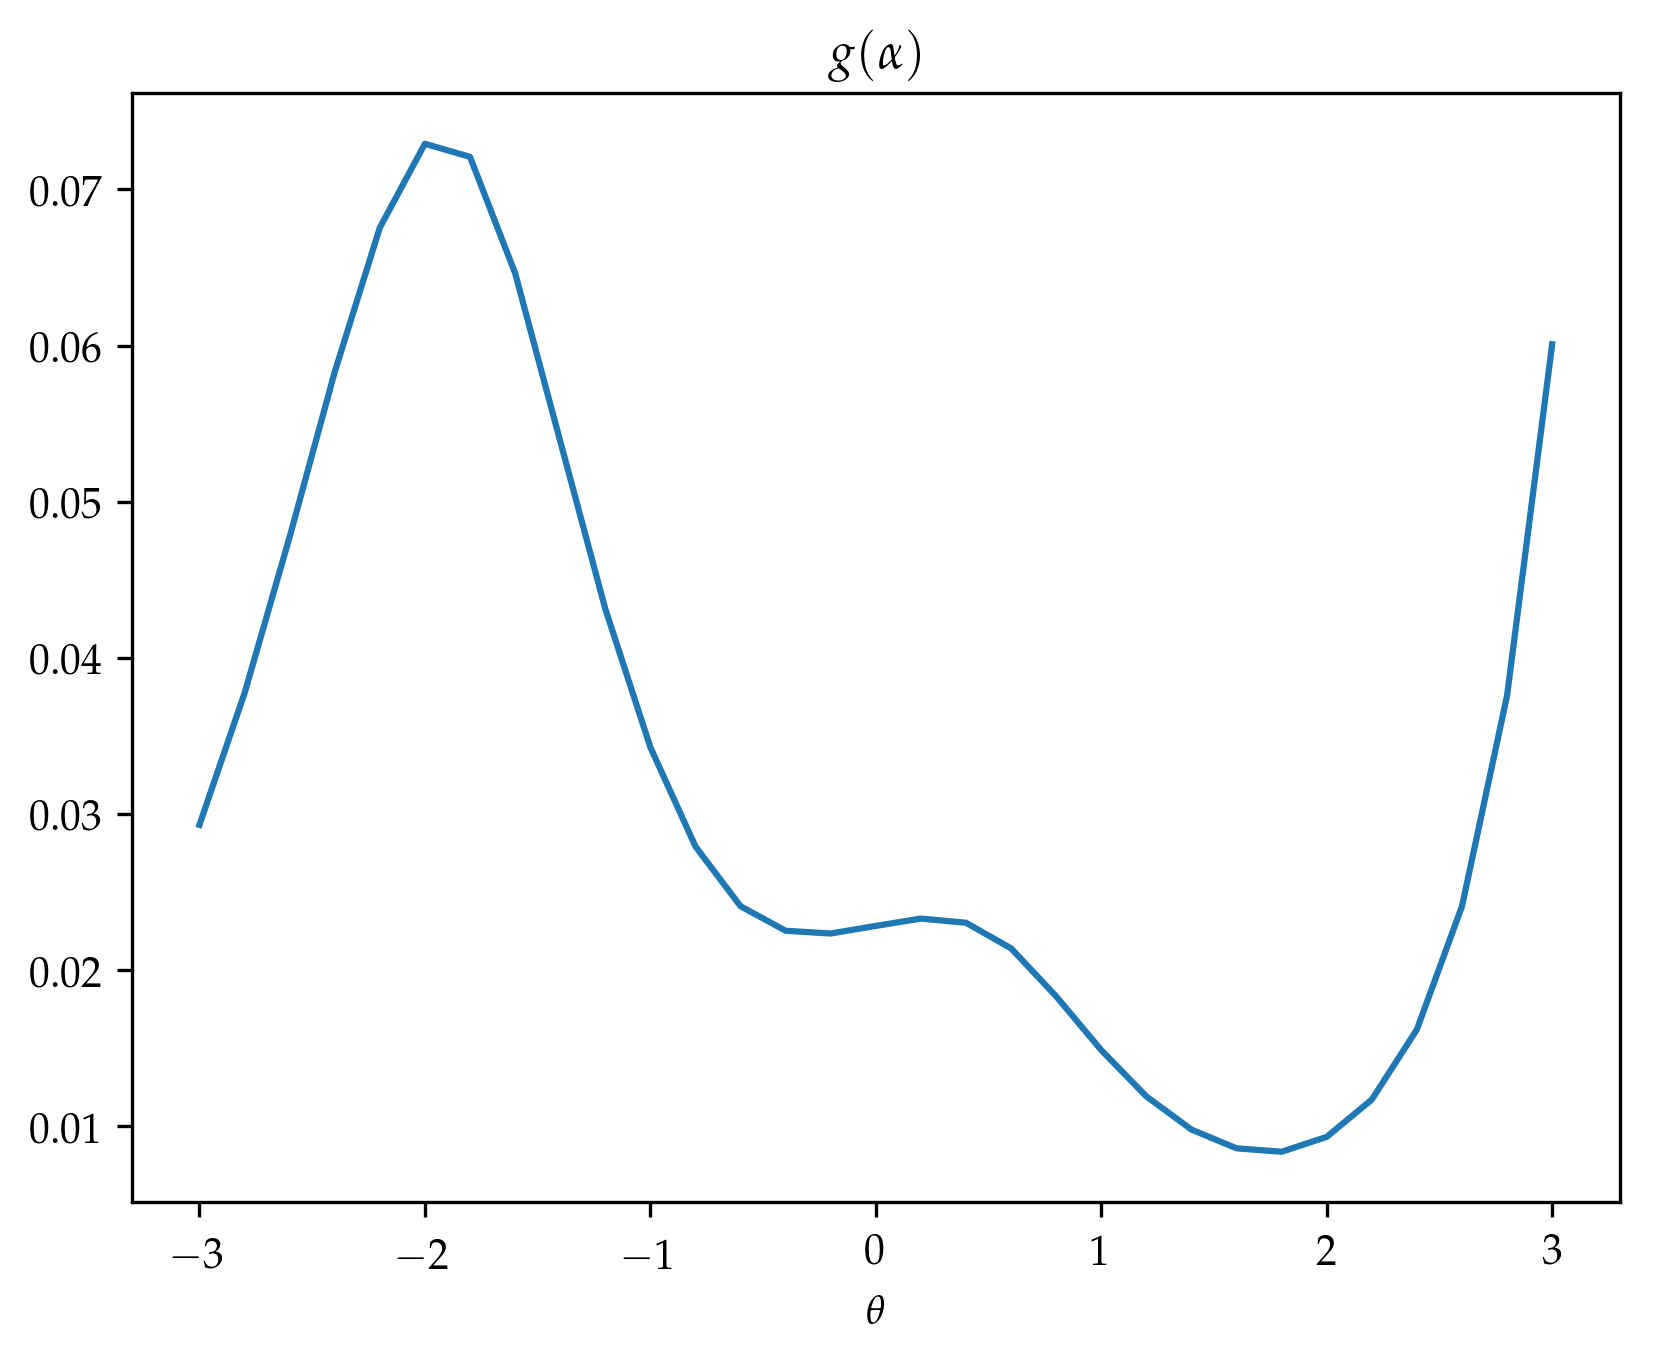

In [6]:
plt.plot(θvec, g_α)
plt.title(L"g(\alpha)")
plt.xlabel(L"\theta")
;

**Now let's do it a few times**

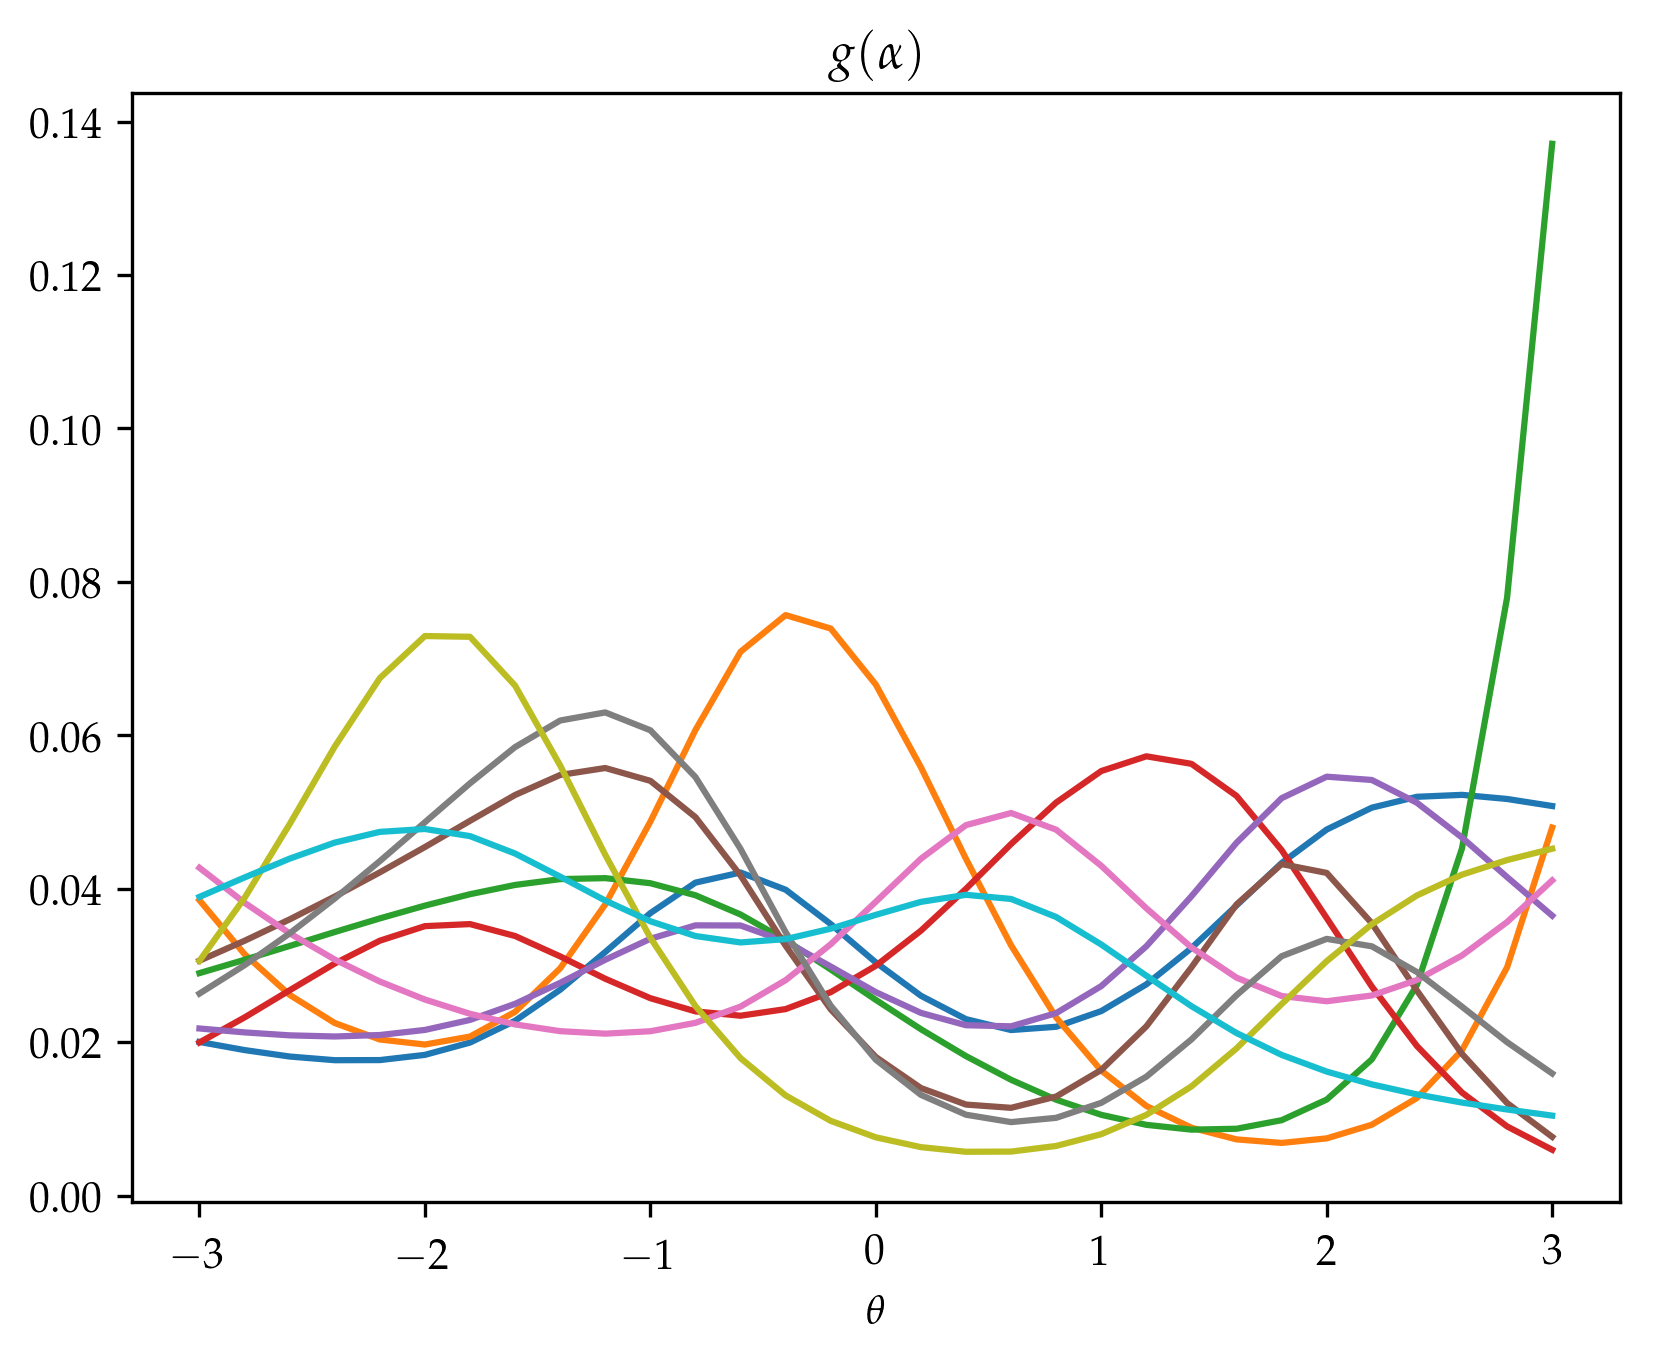

In [7]:
for _ in 1:10
    α = randn(p)
    expQα = exp.(Q*α)
    φ_α = log(sum(expQα))
    g_α = exp.(Q*α - φ_α) # normalized
    plt.plot(θvec, g_α)
end
plt.title(L"g(\alpha)")
plt.xlabel(L"\theta")
;

# Module

I put this family of distributions into a module for easy re-use.
The code is cleaned-up a bit, but there's otherwise nothing new here.

In [8]:
module ExpoFamSpline
    import Distributions: params, partype,
                          logpdf, pdf,
                          UnivariateDistribution,
                          DiscreteUnivariateDistribution, 
                          insupport
    using RCall
    function spline_basis(domain, p)
        R_spline = R"splines::ns($domain, $p)"
        return convert(Matrix{Float64}, R_spline)
    end
    
    struct ExpoSpline{T<:Real} <: DiscreteUnivariateDistribution
        domain::Vector{Float64}
        Qbasis::Matrix{Float64} # basis matrix
        αcoef::Vector{T} # α
        Qα::Vector{T}
        φ_α::T # normalization constant
    end
    function ExpoSpline(domain, Qbasis::Matrix{Float64}, αcoef::Vector{T}) where {T <: Real}
        Qα = Qbasis * αcoef
        φ_α = log_sum_exp(Qα) # equation (10)
        return ExpoSpline(domain, Qbasis, αcoef, Qα, φ_α)
    end
    function ExpoSpline(domain, p::Int, αcoef::Vector{T}) where {T <: Real}
        Q = spline_basis(domain, p)
        return ExpoSpline(domain, Q, αcoef)
    end 
    
    params(d::ExpoSpline) = (d.αcoef)
    partype(d::ExpoSpline{T}) where {T<:Real} = T
    insupport
    
    function log_sum_exp(x)
        # https://en.wikipedia.org/wiki/LogSumExp
        max_x = maximum(x)
        log_sum_exp_x = max_x .+ log(sum(exp.(x .- max_x)))
        return log_sum_exp_x
    end
    logpdf(d::ExpoSpline{T}) where T = d.Qα .- d.φ_α             # equation (9)
    pdf(d::ExpoSpline{T}) where T = exp.(logpdf(d))
    logpdf(d::ExpoSpline{T}, j::Int) where {T} = d.Qα[j] - d.φ_α # equation (9)
    function logpdf(d::ExpoSpline{T}, x::Real) where {T}
        jmax = searchsortedfirst(d.domain, x)
        # must stay within domain
        jmax = max(2, jmax)
        jmax = min(length(d.domain), jmax)
        jmin = max(1, jmax-1)
        lpdf_min = logpdf(d, jmin)
        lpdf_max = logpdf(d, jmax)
        # linear interpolation
        w_max = (x-d.domain[jmin]) / (d.domain[jmax]-d.domain[jmin])
        lpdf_interp = lpdf_min * (1-w_max) + lpdf_max * w_max
        return lpdf_interp
        #logpdf(d, j)
    end
    function pdf(d::ExpoSpline{T}, x::Real) where {T}
        return exp(logpdf(d, x))
    end
    function get_logPi(d::ExpoSpline, noise::UnivariateDistribution, X_i::Float64)
        # unnormalized
        return logpdf.(noise, X_i.-d.domain)
    end
    function get_Pi(d::ExpoSpline, noise::UnivariateDistribution, X_i::Float64)
        # unnormalized
        return pdf.(noise, X_i.-d.domain)
    end
    function loglikelihood(logPi::AbstractVector{Float64}, loggα::Vector{T}) where T<:Real
        return log_sum_exp(logPi .+ loggα)
    end
    function loglikelihood(d::ExpoSpline, logPi::AbstractVector{Float64})
        loggα = logpdf(d)
        return loglikelihood(logPi, loggα)
    end
    function loglikelihood(d::ExpoSpline, noise::UnivariateDistribution, X_i::Float64)
        logPi = get_logPi(d, noise, X_i)
        return loglikelihood(d, logPi)
    end
end

ExpoFamSpline

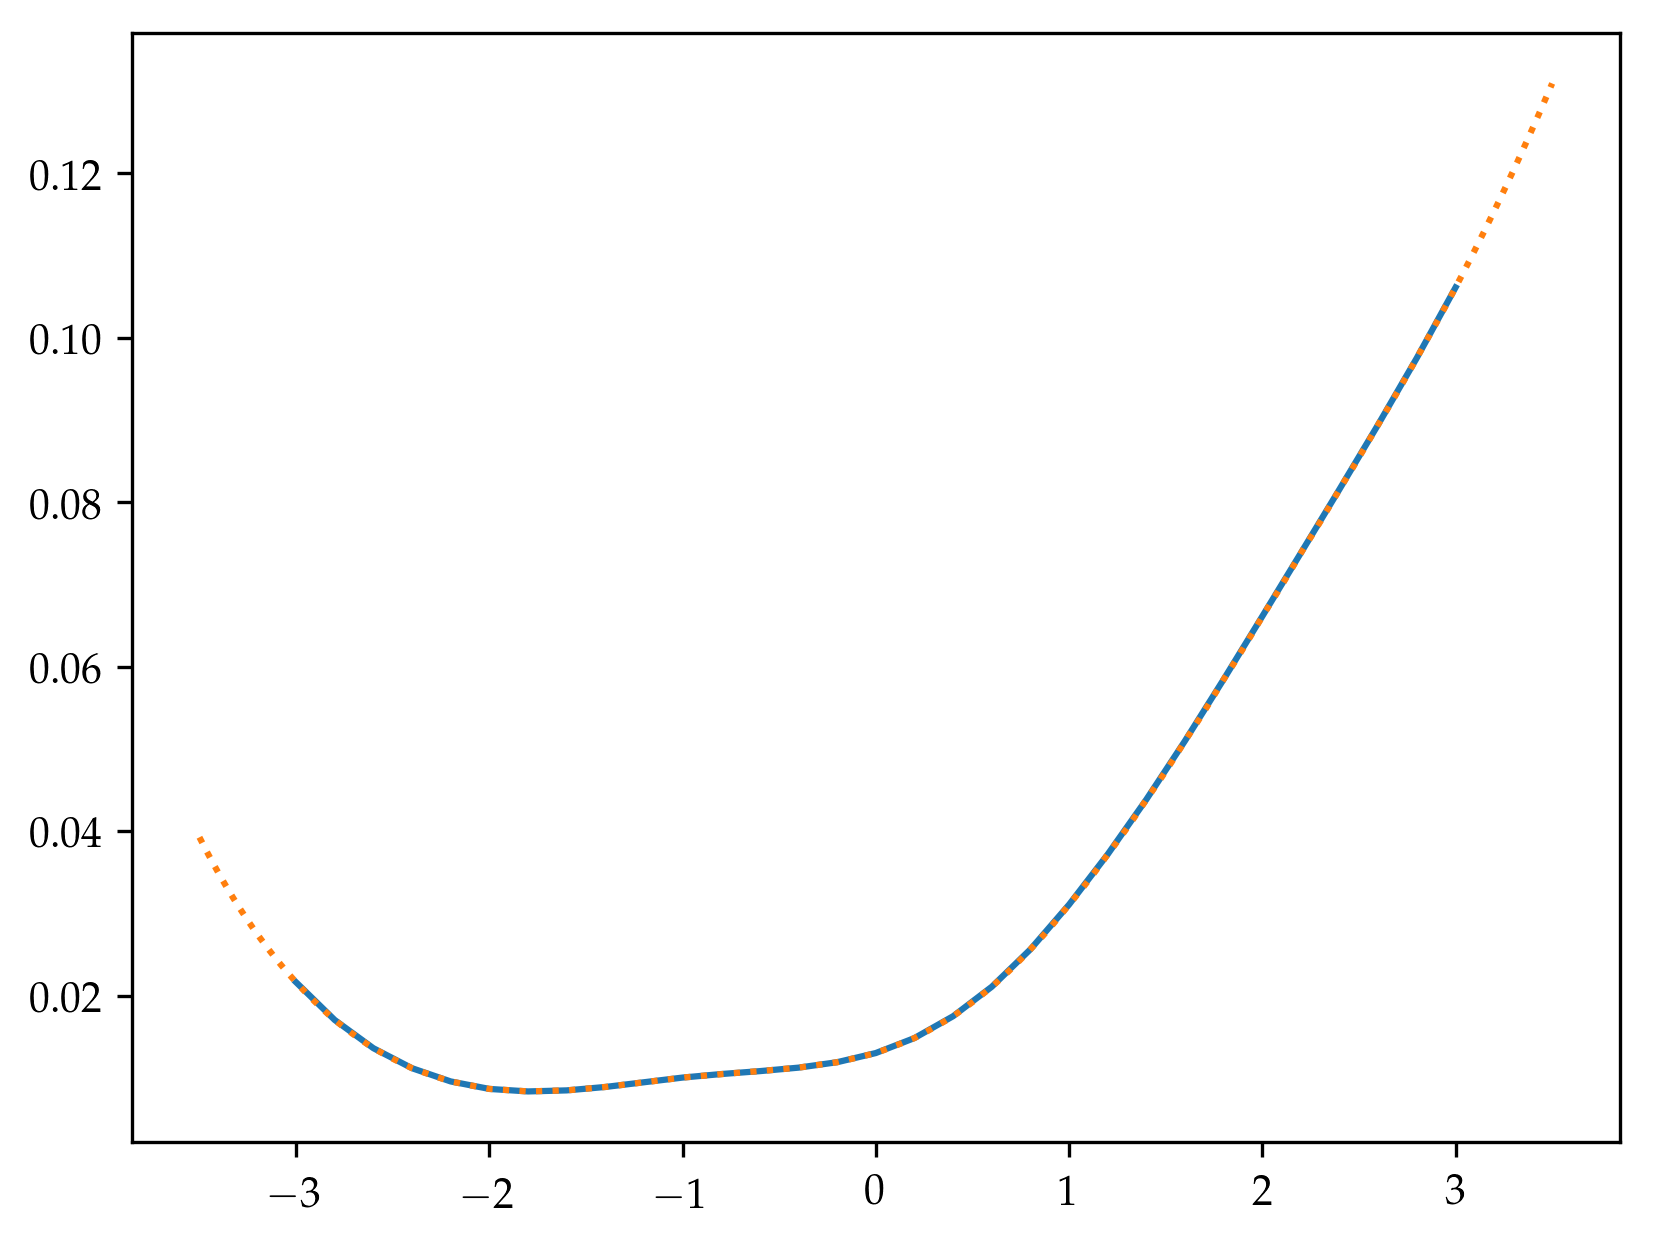

In [9]:
d = ExpoFamSpline.ExpoSpline(θvec, 6, randn(6))
θθ = linspace(-3.5, 3.5, 1000)
plt.plot(θvec, pdf(d))
plt.plot(θθ, pdf.(d, θθ), ":")
;

# Convolution with observation distribution

> Let
> \begin{equation}
    p_{ij} = p_i(X_i \mid \Theta_i = \theta_j)
\end{equation}
> be the probability that $X_i$ equals its observed value if $\Theta_i$ equals $\theta_j$ and define $P_i$ to be the $m$-vector of possible such probabilities for $X_i$: $P_i=(p_{i1}, \dotsc, p_{im})\trans$.
> In our discrete setting, the marginal probability (6) for $X_i$ becomes
> \begin{equation}
    P(X_i \mid \alpha) = f_i(\alpha) = \sum_{j=1}^m p_{ij} g_j(\alpha) = P_i\trans g(\alpha)
    \,.
\end{equation}

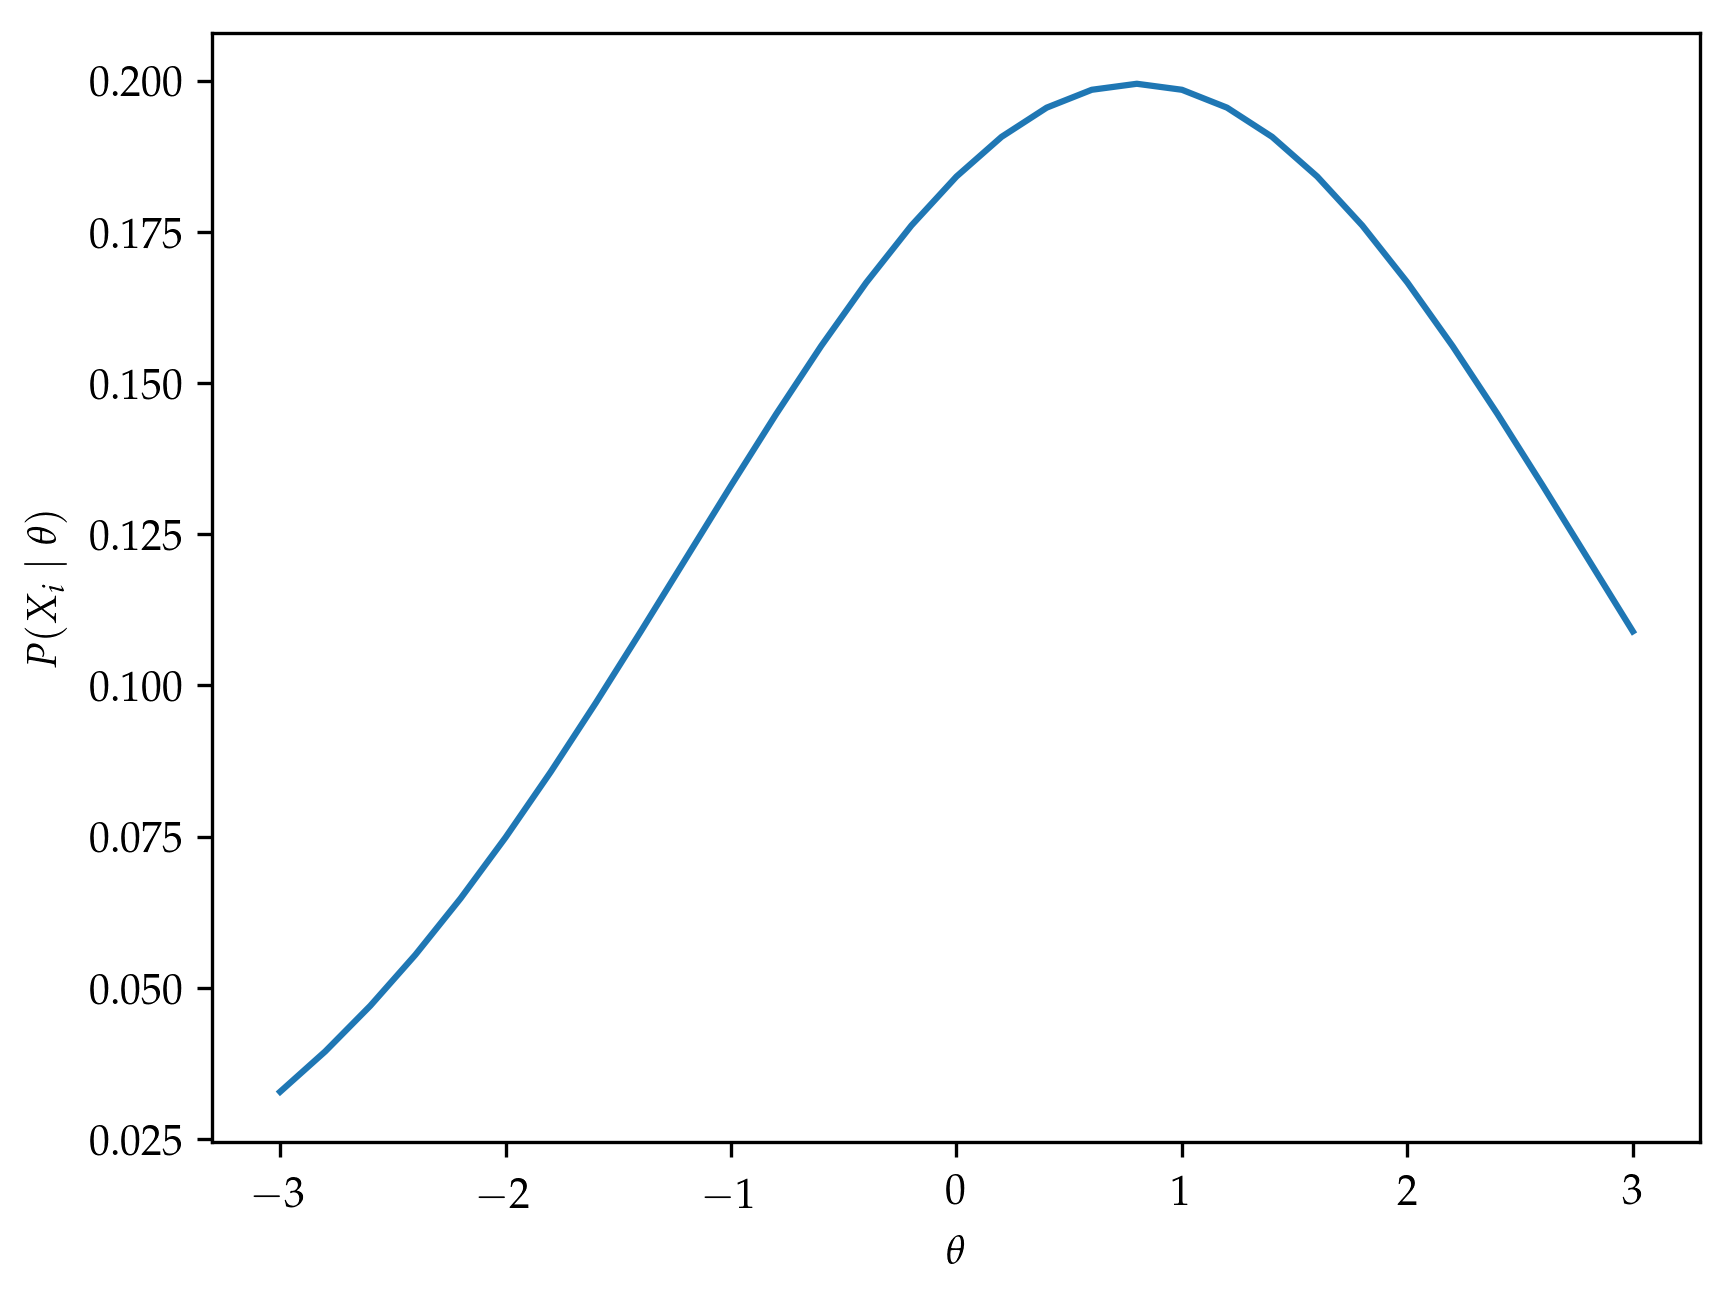

In [10]:
function get_Pi(Θdomain::Vector{Float64}, noise::UnivariateDistribution, X_i::Float64)
    # normalization?
    pdf.(noise, X_i.-Θdomain)
end
Pi = get_Pi(d.domain, Normal(0, 2), 0.8)
plt.plot(d.domain, Pi)
plt.xlabel(L"\theta")
plt.ylabel(L"P(X_i \mid \theta)")
;

In [11]:
@time ExpoFamSpline.loglikelihood(d, Normal(0, 2), 0.5)

  0.083293 seconds (54.90 k allocations: 2.553 MiB)


-1.9916964240085977

# Efron simulation

> Figure 1 illustrates an artificial deconvolution problem in which $g(\theta)$ is a mixture of one-eighth $\unif([-3,3])$ and seven-eighths $\normal(0, 0.5^2)$,
> \begin{equation}
    g(\theta) = \frac{1}{8} \frac{I_{(-3,3)}(\theta)}{6} 
    + \frac{7}{8} \frac{1}{(2\pi\sigma^2)^{1/2}}
      \exp\del{-\frac{1}{2}\frac{\theta^2}{\sigma^2}}
      ,\quad
      \sigma=0.5
      \,,
\end{equation}
> with normal observations $X_i \sim \normal(\Theta_i, 1)$ as in (5), a reduced case.

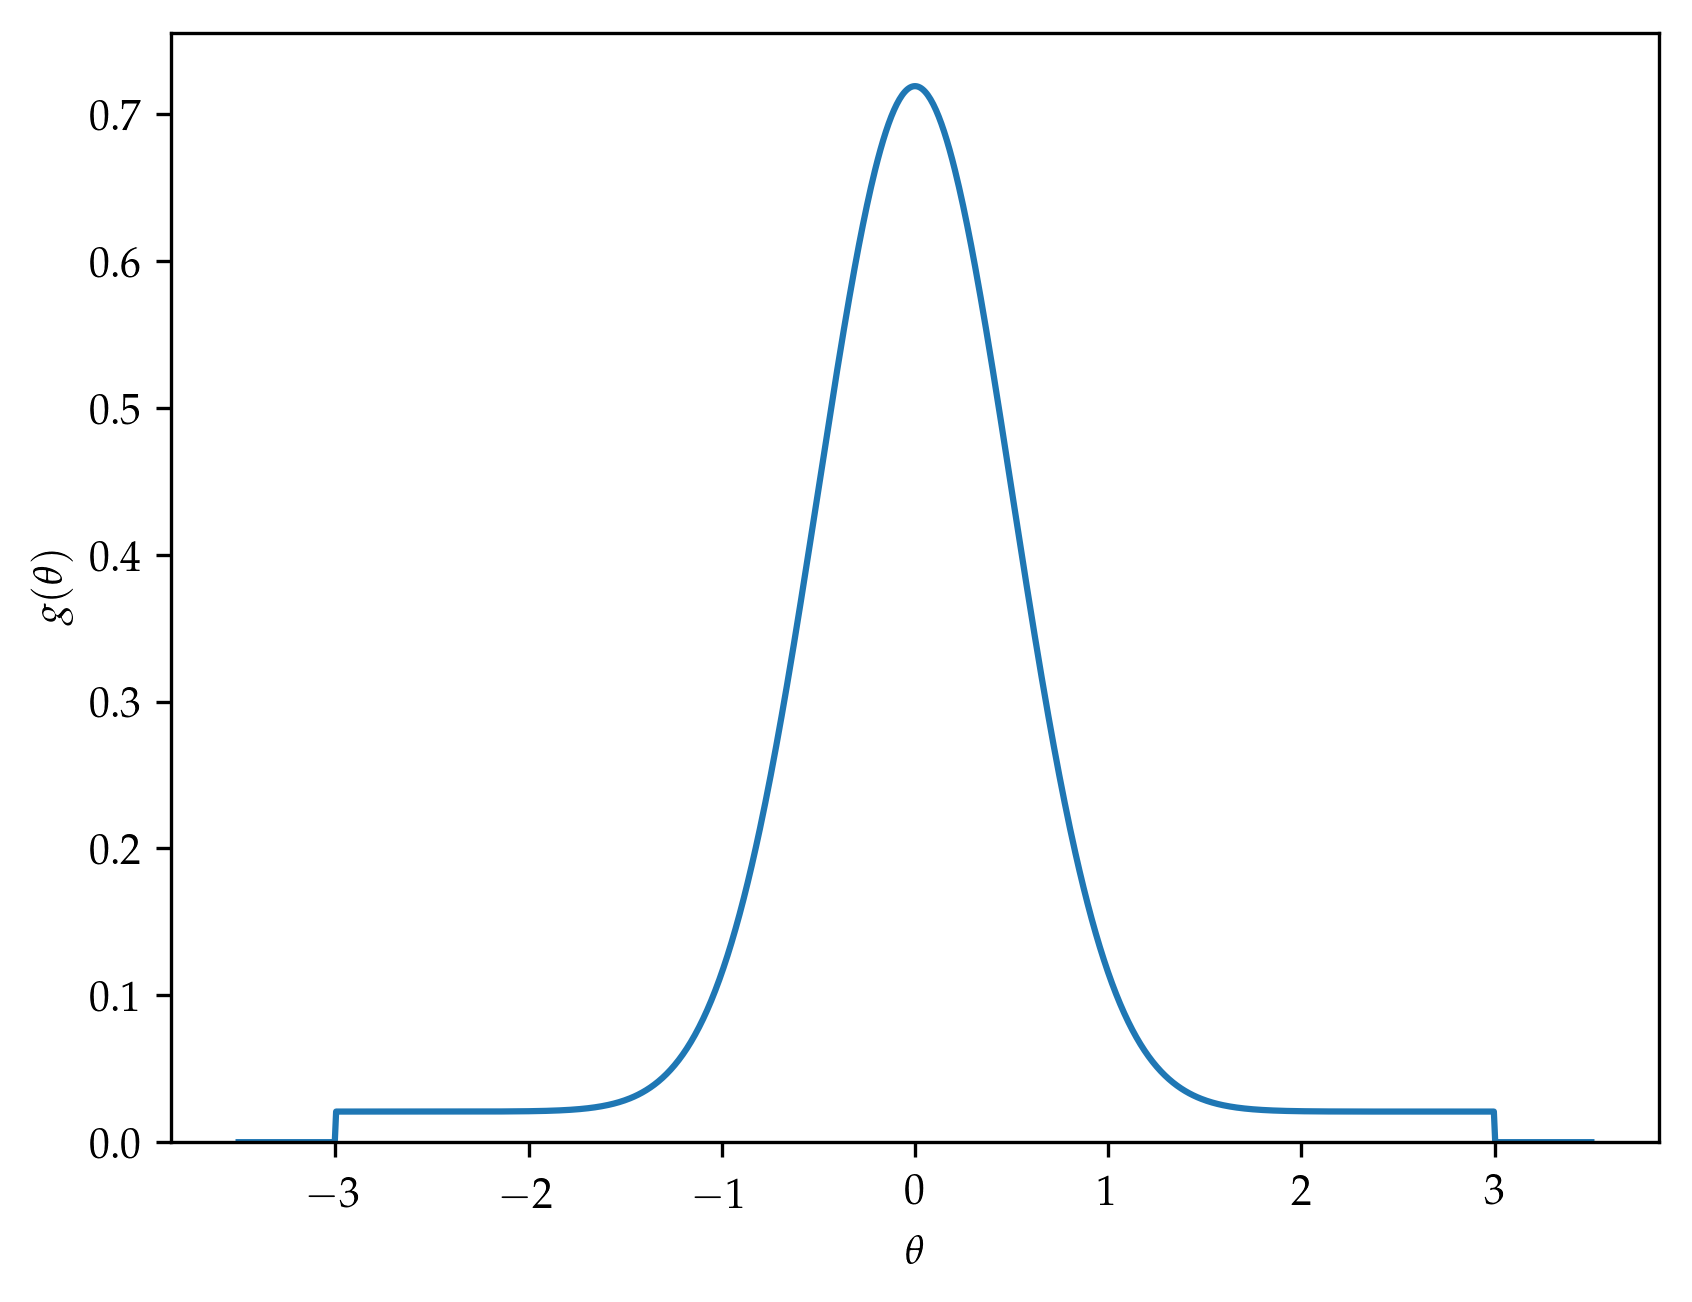

In [12]:
# Mixture models are very simple to create in julia:
example_gθ = MixtureModel(
        [Uniform(-3,3), Normal(0, 0.5)], # components
        [1/8, 7/8]                       # weights
        )
example_noise = Normal(0, 1)
xx = linspace(-3.5, 3.5, 1000)
plt.plot(xx, pdf.(example_gθ, xx), label=L"g(\theta)")
plt.ylabel(L"g(\theta)")
plt.xlabel(L"\theta")
plt.ylim(0.0)
;

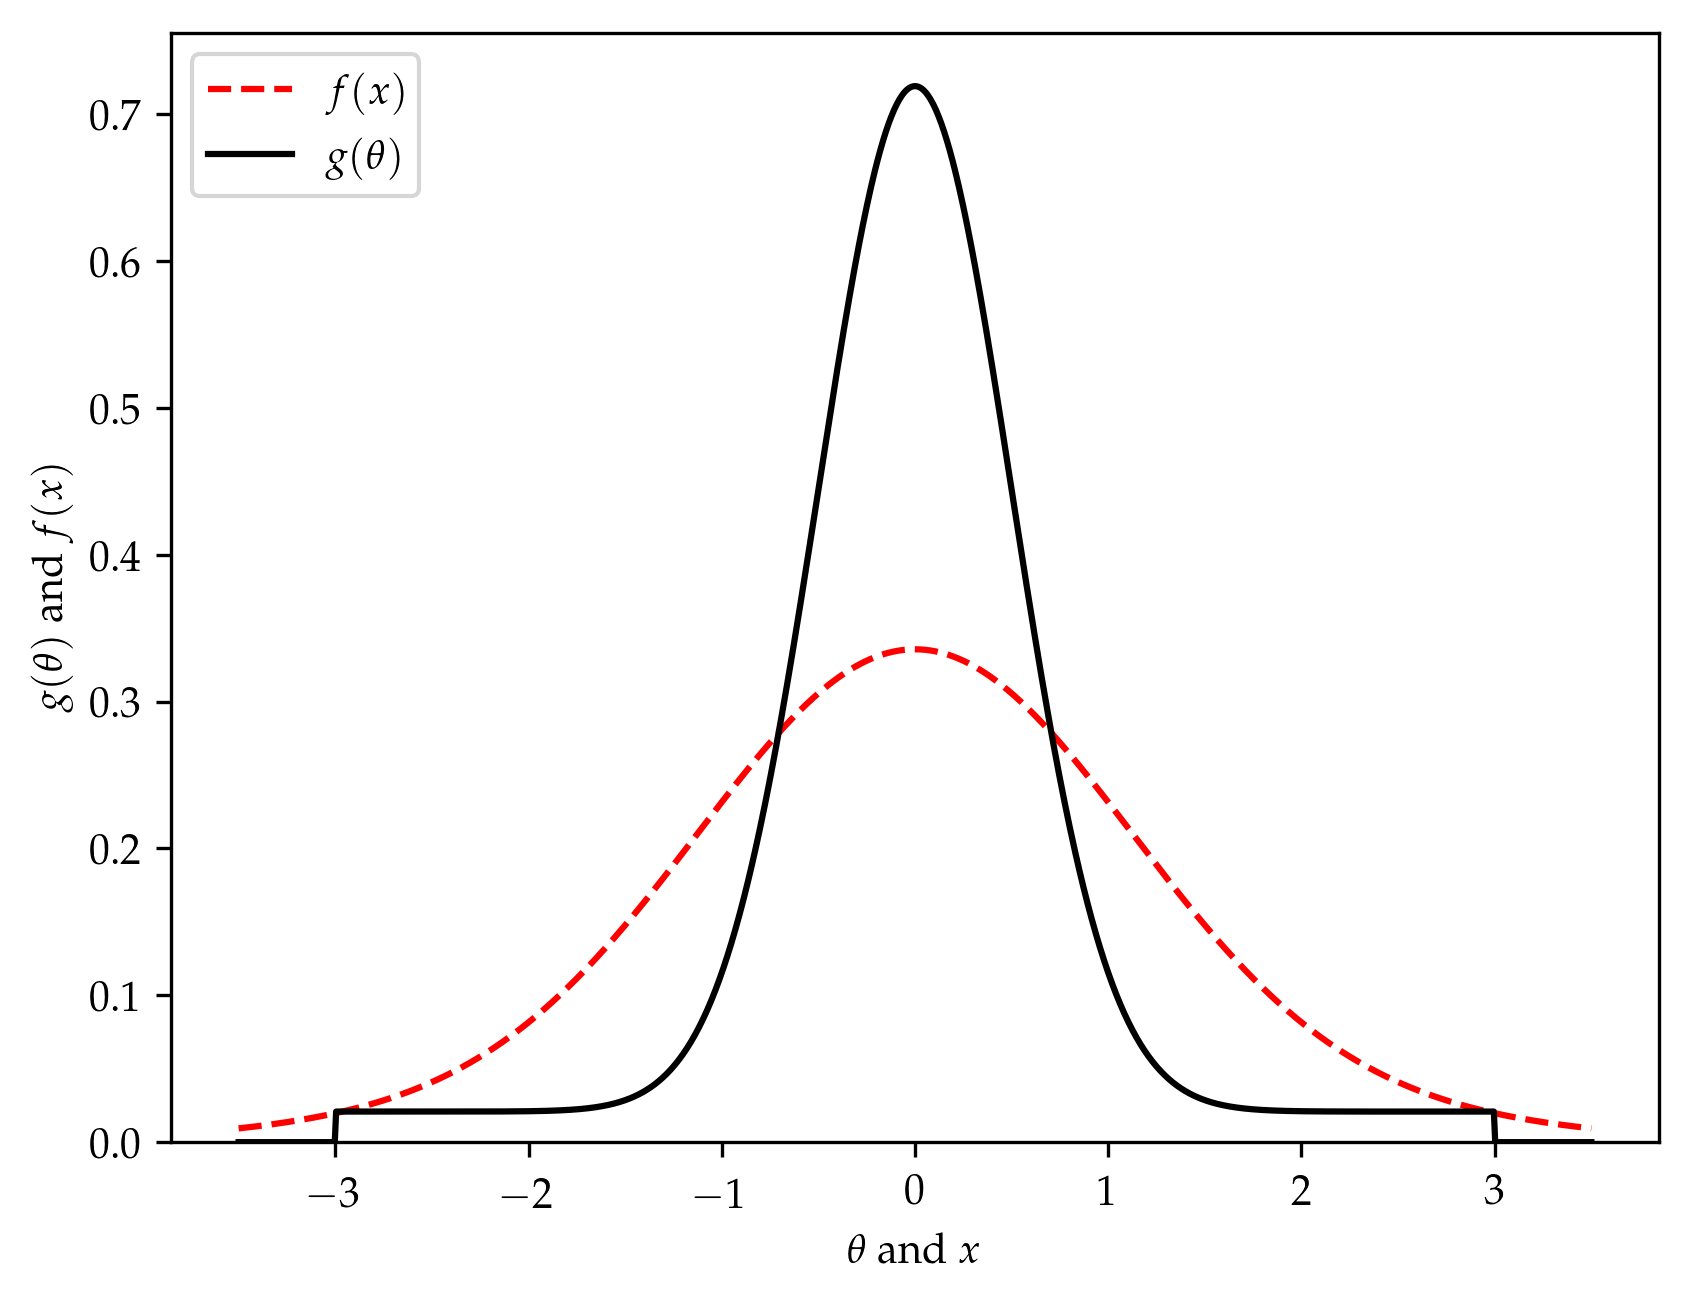

In [87]:
function convolved_log_fx(gθ::Distribution, θgrid::AbstractVector{Float64}, noise::Distribution, x_i::Float64)
    gθ_lpdf = logpdf.(gθ, θgrid)
    noise_lpdf = logpdf.(noise, x_i.-θgrid)
    return ExpoFamSpline.log_sum_exp(gθ_lpdf .+ noise_lpdf)
end

f_x_unnormalised = exp.([convolved_log_fx(example_gθ, linspace(-3.0, 3.0, 41), example_noise, x) for x in xx])
f_x_normalised = f_x_unnormalised ./ sum(StatsBase.midpoints(f_x_unnormalised) .* diff(xx))
plt.plot(xx, f_x_normalised, label=L"f(x)", color="red", linestyle="--")
plt.plot(xx, pdf.(example_gθ, xx), label=L"g(\theta)", color="black")
plt.ylabel(L"$g(\theta)$ and $f(x)$")
plt.xlabel(L"$\theta$ and $x$")
plt.ylim(0.0)
plt.legend(loc="upper left")
;

In [14]:
# # convolved distribution: add characteristic functions
# ω = linspace(-10.0, 10.0, 1000)
# cf_g = cf.(example_gθ, ω)
# cf_noise = cf.(example_noise, ω)
# cf_f = cf_g .+ cf_noise
# plt.plot(ω, cf_f)

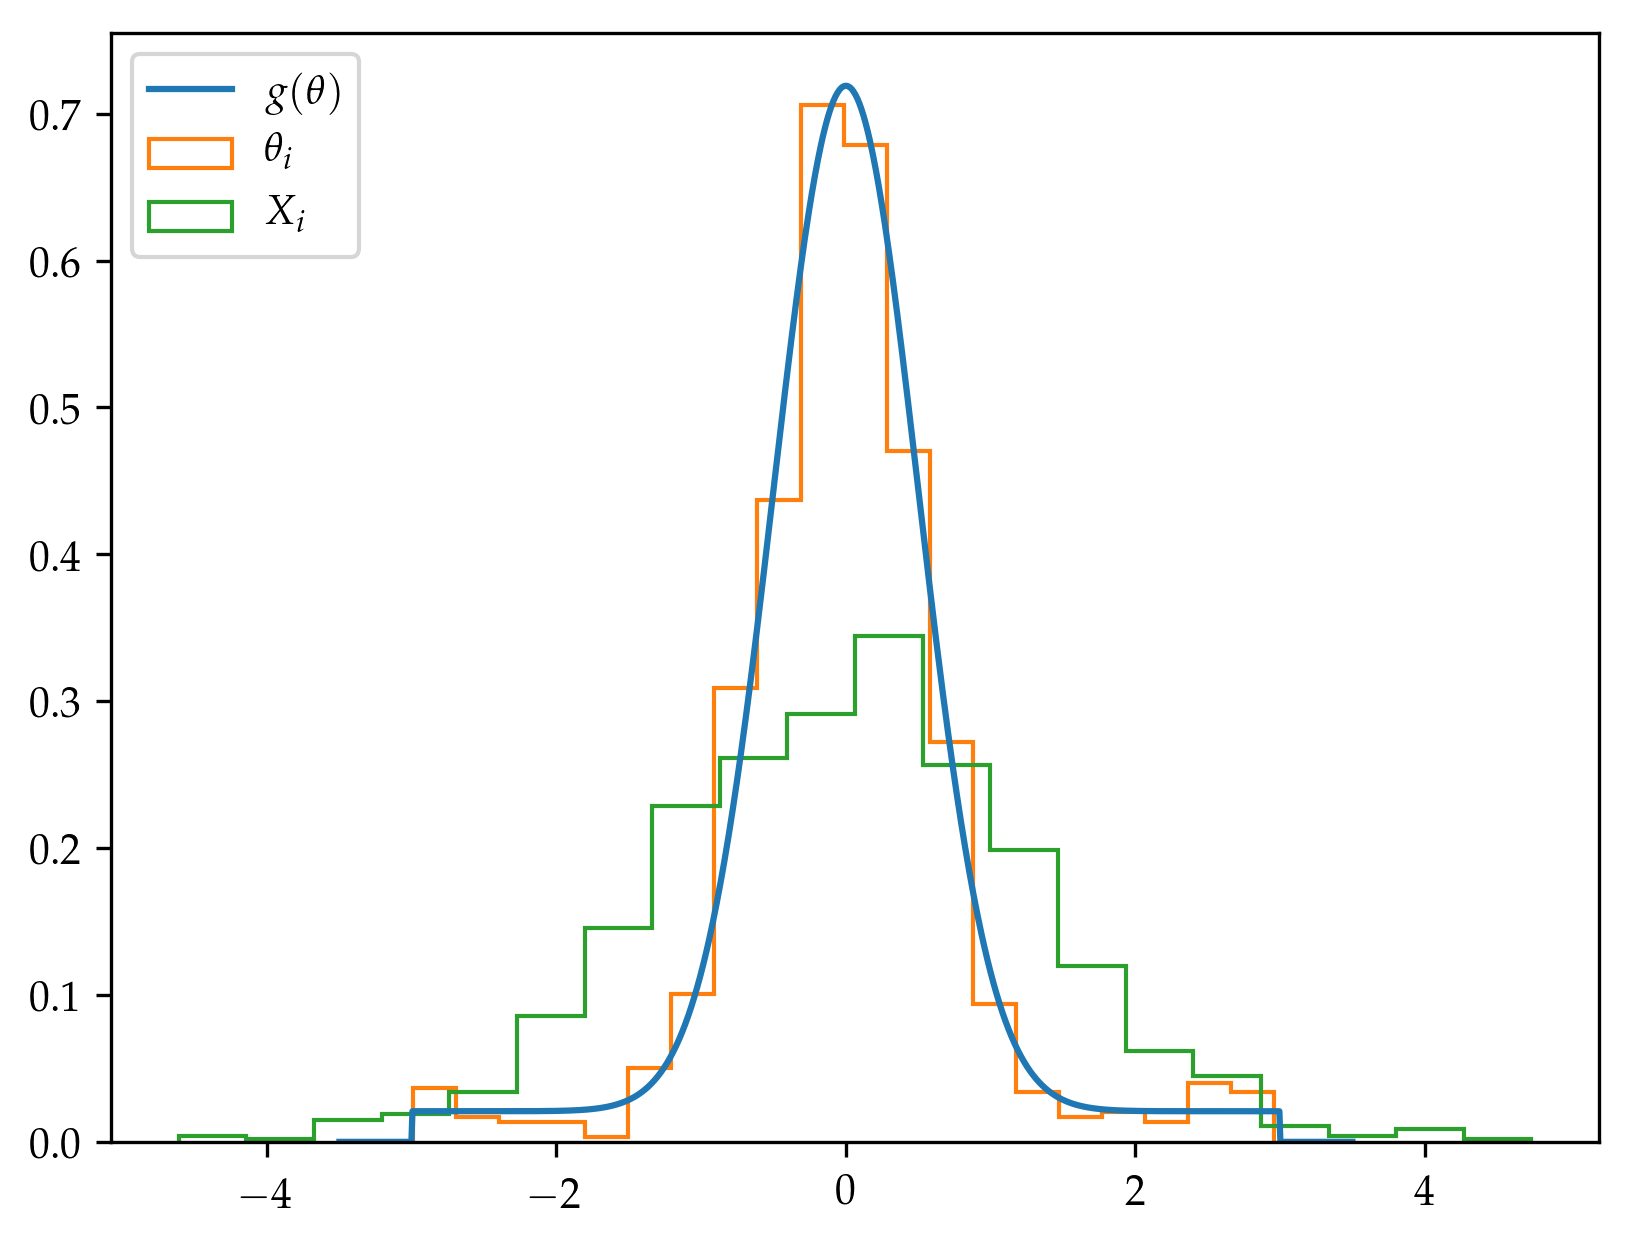

In [15]:
N = 1000
θ_sim = rand(example_gθ, N)
X_sim = θ_sim .+ rand(example_noise, N)
plt.plot(xx, pdf.(example_gθ, xx), label=L"g(\theta)")
plt.plt[:hist](θ_sim, histtype="step", normed=true, label=L"\theta_i", bins=20)
plt.plt[:hist](X_sim, histtype="step", normed=true, label=L"X_i", bins=20)
plt.legend(loc="upper left")
;

# Spline log-likelihood

## noise-free

In [16]:
# noise-free
sum(logpdf.(d, θ_sim))

-4194.021303931874

In [17]:
@time sum(logpdf.(d, θ_sim));

  0.000184 seconds (32 allocations: 9.188 KiB)


## noisy

In [18]:
sum(ExpoFamSpline.loglikelihood.(d, Normal(0,1), X_sim))

-2288.4976414163953

In [19]:
@time sum(ExpoFamSpline.loglikelihood.(d, Normal(0,1), X_sim));

  0.001825 seconds (4.06 k allocations: 1.536 MiB)


# Autodifferentiation of log-likelihood

Here we obtain the gradient of the noise-free log-likelihood using forward auto-differentiation.

In [20]:
using ForwardDiff

## noise-free

In [21]:
# create likelihood function
likelihood = α -> sum(logpdf.(ExpoFamSpline.ExpoSpline(θvec, d.Qbasis, α), θ_sim))
likelihood(d.αcoef)

-4194.021303931874

In [22]:
ForwardDiff.gradient(likelihood, d.αcoef)

6-element Array{Float64,1}:
  174.743
  390.632
   42.168
 -191.777
 -193.597
 -167.31 

On my computer, it takes less than 1 millisecond to compute the noise-free gradient of the log-likelihood with 1,000 simulated observations.

In [23]:
@time ForwardDiff.gradient(likelihood, d.αcoef);

  0.000379 seconds (48 allocations: 61.203 KiB)


## noisy

In [31]:
loglik_w_noise = α -> sum(ExpoFamSpline.loglikelihood.(ExpoFamSpline.ExpoSpline(θvec, d.Qbasis, α), Normal(0,1), X_sim))
loglik_w_noise(d.αcoef)

-2288.4976414163953

In [26]:
ForwardDiff.gradient(loglik_w_noise, d.αcoef)

6-element Array{Float64,1}:
   85.6458
  103.647 
   58.9244
  -67.2009
  -76.3169
 -159.846 

On my computer, it takes about 6 milliseconds to compute the noise-free gradient of the log-likelihood with 1,000 simulated observations.

In [27]:
@time for _ in 1:100;ForwardDiff.gradient(loglik_w_noise, d.αcoef);end;

  0.467748 seconds (405.70 k allocations: 625.504 MiB, 32.15% gc time)


**Pre-compute $P_i$'s**

In [58]:
function make_loglik_w_noise_pre(d::ExpoFamSpline.ExpoSpline, noise, X::Vector{Float64})
    logP = ExpoFamSpline.get_logPi.(d, noise, X)
    mloglik_w_noise_pre = (α) -> -sum(ExpoFamSpline.loglikelihood.(
        ExpoFamSpline.ExpoSpline(d.domain, d.Qbasis, α), 
        logP))
    return mloglik_w_noise_pre
end

make_loglik_w_noise_pre (generic function with 1 method)

In [59]:
@which make_loglik_w_noise_pre(d, Normal(0,1), X_sim)

make_loglik_w_noise_pre(d::ExpoFamSpline.ExpoSpline, noise, X::Array{Float64,1}) in Main at In[58]:2

In [60]:
f = make_loglik_w_noise_pre(d, Normal(0,1), X_sim)
f(d.αcoef)

2288.4976414163953

It's a little bit faster (4 ms instead of 6 ms).

In [61]:
@time for _ in 1:100;ForwardDiff.gradient(f, d.αcoef);end;

  0.785221 seconds (636.47 k allocations: 607.592 MiB, 15.51% gc time)


# Optimize log-likelihood

In [44]:
using Optim

In [74]:
d.αcoef

6-element Array{Float64,1}:
 -0.675449
 -0.69816 
  0.424721
  1.51127 
  0.433706
  2.26828 

In [94]:
od = OnceDifferentiable(f, copy(d.αcoef); autodiff=:forward)
@time opt_out = optimize(od, ones(d.αcoef), LBFGS(), Optim.Options(f_tol=1e-10, x_tol=1e-10))

  1.374871 seconds (1.97 M allocations: 2.853 GiB, 15.96% gc time)


Results of Optimization Algorithm
 * Algorithm: L-BFGS
 * Starting Point: [1.0,1.0,1.0,1.0,1.0,1.0]
 * Minimizer: [6.810984017441978,-1.6492784110013972, ...]
 * Minimum: 1.670571e+03
 * Iterations: 150
 * Convergence: true
   * |x - x'| ≤ 1.0e-10: false 
     |x - x'| = 7.09e-02 
   * |f(x) - f(x')| ≤ 1.0e-10 |f(x)|: true
     |f(x) - f(x')| = 2.42e-11 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 2.08e-04 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 490
 * Gradient Calls: 490

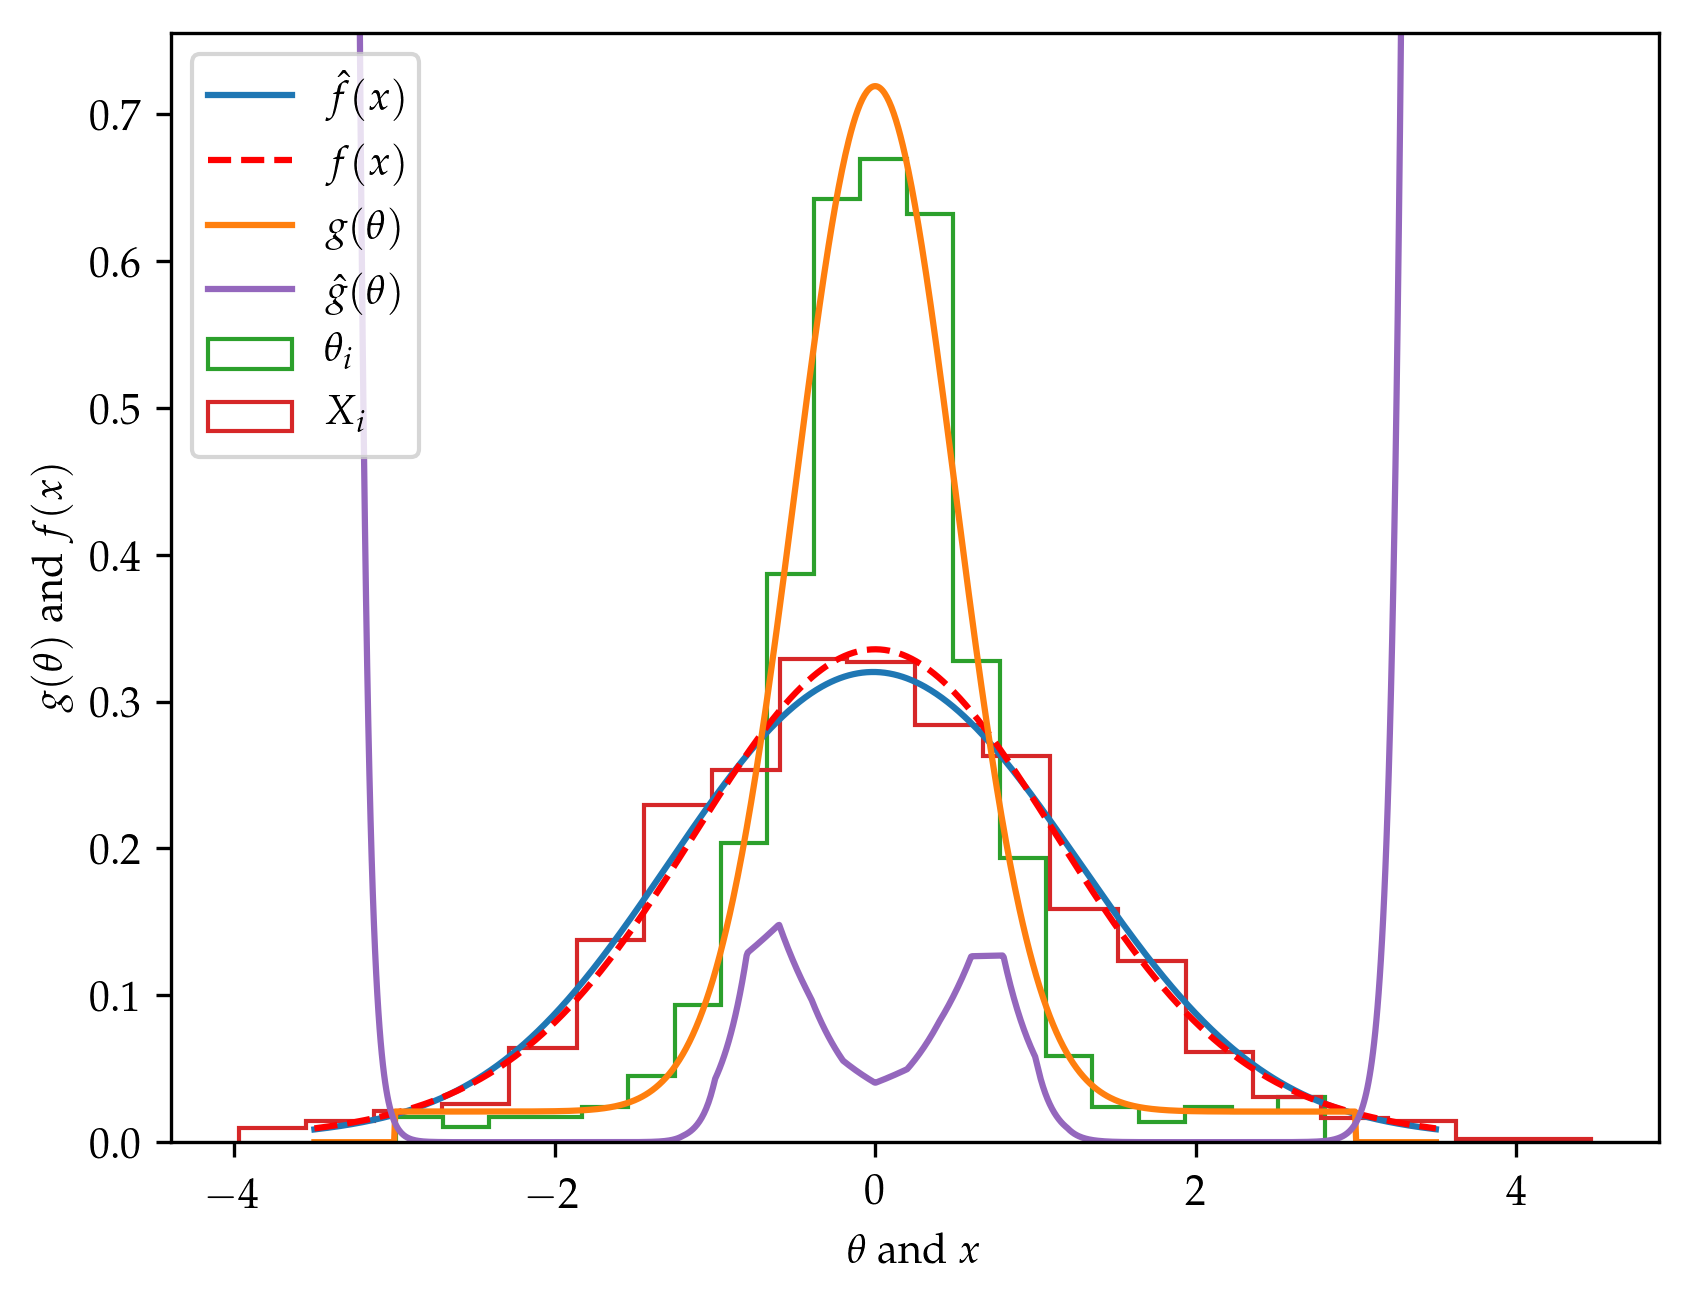

In [95]:
d_optim = ExpoFamSpline.ExpoSpline(d.domain, d.Qbasis, Optim.minimizer(opt_out))

f_x_unnormalised = exp.([convolved_log_fx(d_optim, d_optim.domain, Normal(0,1), x) for x in xx])
f_x_normalised = f_x_unnormalised ./ sum(StatsBase.midpoints(f_x_unnormalised) .* diff(xx))
plt.plot(xx, f_x_normalised, label=L"\hat{f}(x)")

f_x_unnormalised = exp.([convolved_log_fx(example_gθ, linspace(-3.0, 3.0, 41), example_noise, x) for x in xx])
f_x_normalised = f_x_unnormalised ./ sum(StatsBase.midpoints(f_x_unnormalised) .* diff(xx))
plt.plot(xx, f_x_normalised, label=L"f(x)", color="red", linestyle="--")

plt.plot(xx, pdf.(example_gθ, xx), label=L"g(\theta)")
plt.plt[:hist](θ_sim, histtype="step", normed=true, label=L"\theta_i", bins=20)
plt.plt[:hist](X_sim, histtype="step", normed=true, label=L"X_i", bins=20)
_ylim = plt.ylim()
plt.plot(xx, pdf.(d_optim, xx), label=L"\hat{g}(\theta)")
plt.ylim(_ylim)
plt.ylabel(L"$g(\theta)$ and $f(x)$")
plt.xlabel(L"$\theta$ and $x$")
plt.legend(loc="upper left")
;

Next steps:
- compute the derivative of the PDF
- maximize the PDF to obtain the MLE given noise-free data
- add a noise likelihood and propagate the gradient
- maximize the likelihood to obtain the MLE given noisy data